In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm


Realizamos la carga de la serie de tiempo del IPC generada por el INE de Guatemala, mes a mes.


In [6]:
df = pd.read_csv("ipc.txt")

#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head(5)

,Total
Date,
2011-04-01,103.17
2011-05-01,103.68
2011-06-01,104.23
2011-07-01,105.22
2011-08-01,105.85


Observamos el estado del IPC a lo largo del tiempo proporcionado.

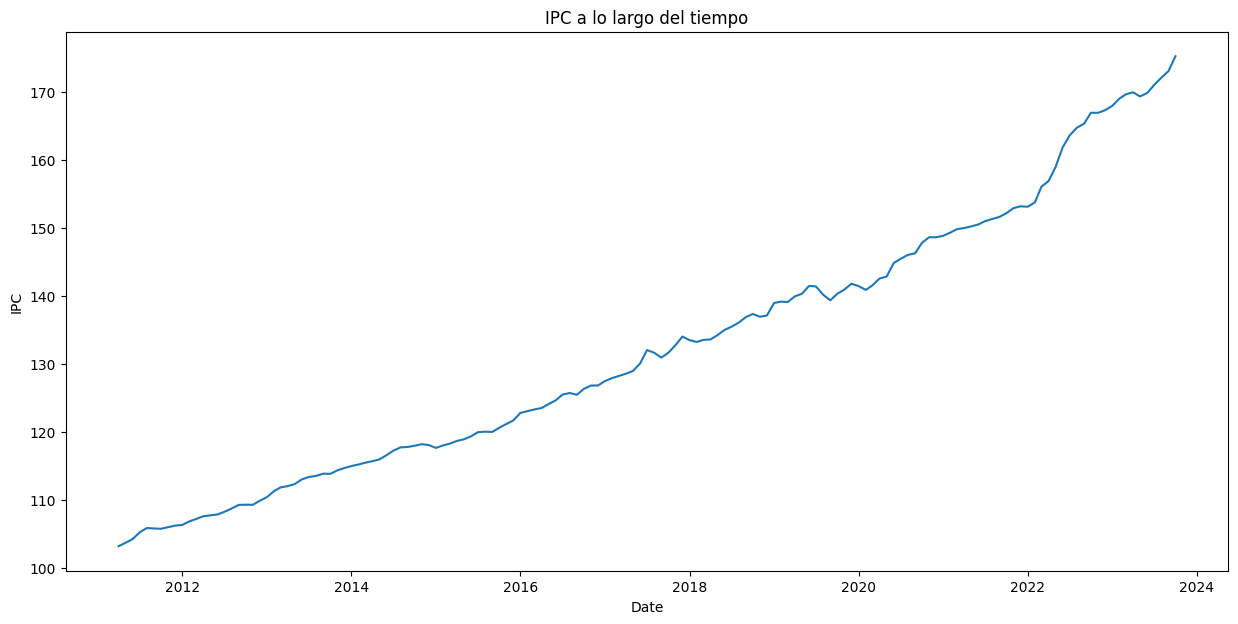

In [7]:
plt.figure(figsize=(15,7))
plt.title("IPC a lo largo del tiempo")
plt.xlabel('Date')
plt.ylabel('IPC')
plt.plot(df)
plt.show()

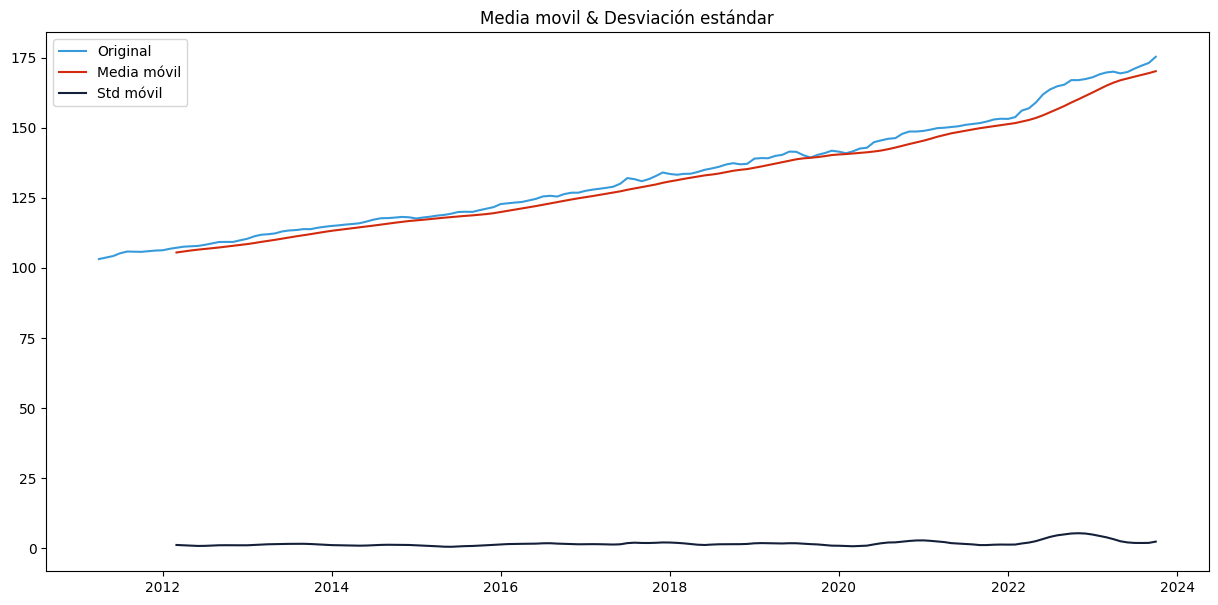

In [11]:
#Determinando las estadísticas móviles
df["rolling_avg"] = df["Total"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Total"].rolling(window=12).std()

#Gráficas de estadísticas móviles
plt.figure(figsize=(15,7))
plt.plot(df["Total"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Media móvil')
plt.plot(df["rolling_std"], color='#142039', label='Std móvil')
plt.legend(loc='best')
plt.title('Media movil & Desviación estándar')
plt.show(block=False)

La prueba Aumentada de Dickey-Fuller se utiliza para determinar si una serie de tiempo es estacionaria. Fijaremos un nivel de significancia antes de la prueba y haremos conclusiones sobre la hipótesis basándonos en el resultado del valor p (o p_value).
$$
H_{0}: \text{ Los datos no son estacionarios}\\
H_{a}: \text{ Los datos son estacionarios} 
$$

In [13]:
#Prueba Dickey-Fuller aumentada:
print('Resultados de la prueba Dickey Fuller:')
dftest = adfuller(df['Total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Estadístico','p-value','#Lags Utilizados','Número de observaciones utilizado'])
for key,value in dftest[4].items():
    dfoutput['Valor crítico (%s)'%key] = value
    
print(dfoutput)

Resultados de la prueba Dickey Fuller:
Test Estadístico                       3.117435
p-value                                1.000000
#Lags Utilizados                       2.000000
Número de observaciones utilizado    148.000000
Valor crítico (1%)                    -3.475325
Valor crítico (5%)                    -2.881275
Valor crítico (10%)                   -2.577293
dtype: float64


Aunque sabemos que nuestros valores son estacionarios

$$
p_{value} = 1
$$

veamos qué tal se comporta un modelo ARIMA estándar con la serie de tiempo del IPC.

Utilizando la función auto_arima del paquete pmdarima, podemos realizar una búsqueda de parámetros para los valores óptimos del modelo.

In [14]:
#Modelo estándar ARIMA
ARIMA_model = pm.auto_arima(df['Total'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # Utilizar adftest para encontrar un 'd' óptimo
                      max_p=3, max_q=3, # p y q máximo
                      m=1, # Frecuencia de las series (si m==1, el factor estacional se configura como falso)
                      d=None,# Que el modelo determine el 'd'
                      seasonal=False, # No hay estacionalidad para el ARIMA estándar
                      trace=False, #logs 
                      error_action='warn', # Muestra errores ('ignore' los apaga)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -122.779
Date:                Fri, 24 Nov 2023   AIC                            251.558
Time:                        07:07:37   BIC                            260.590
Sample:                    04-01-2011   HQIC                           255.228
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4851      0.069      7.080      0.000       0.351       0.619
ma.L1          0.3955      0.053      7.433      0.000       0.291       0.500
sigma2         0.3006      0.027     11.084      0.0

DIAGNÓSTICO DE MODELO

De la función plot_diagnostics, resultan cuatro gráficas:

1. Standarized residual: No hay patrones obvios en los residuos, con valores que tienne una media de cero y una varianza constante.

2. Histogram plus KDE estimate: La curva KDE debe ser muy similar a la distribución normal.

3. Normal Q-Q: La mayoría de los puntos de datos deben situarse en la línea recta.

4. Correlogram (ACF plot): El 95% de las correlaciones para un retardo superior a cero no deberían ser significativas. La zona gris es la banda de confianza, y si los valores caen fuera de ella, entonces son estadísticamente significativos. En nuestro caso, no se observan valores fuera de esta zona, por lo tanto, es posible que no tengamos que añadir más predictores.


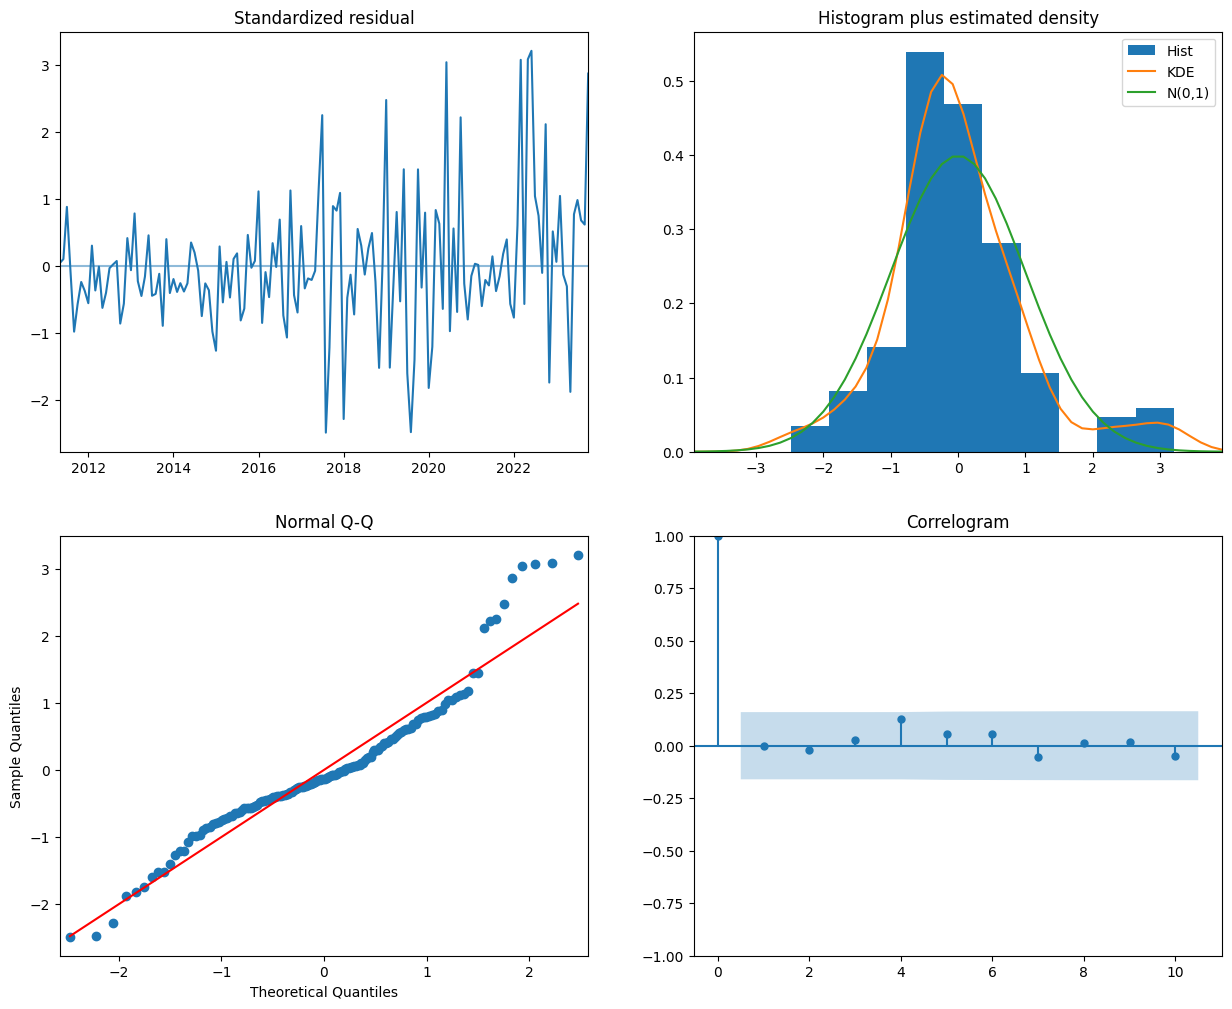

In [15]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Ahora, podemos utilizar el modelo para predecir el IPC de Guatemala en los próximos 24 meses.

Como podemos ver en el gráfico siguiente, no parece un pronóstico muy exacto. Quizás debemos cambiar la estructura del modelo para que tenga en cuenta la estacionalidad.

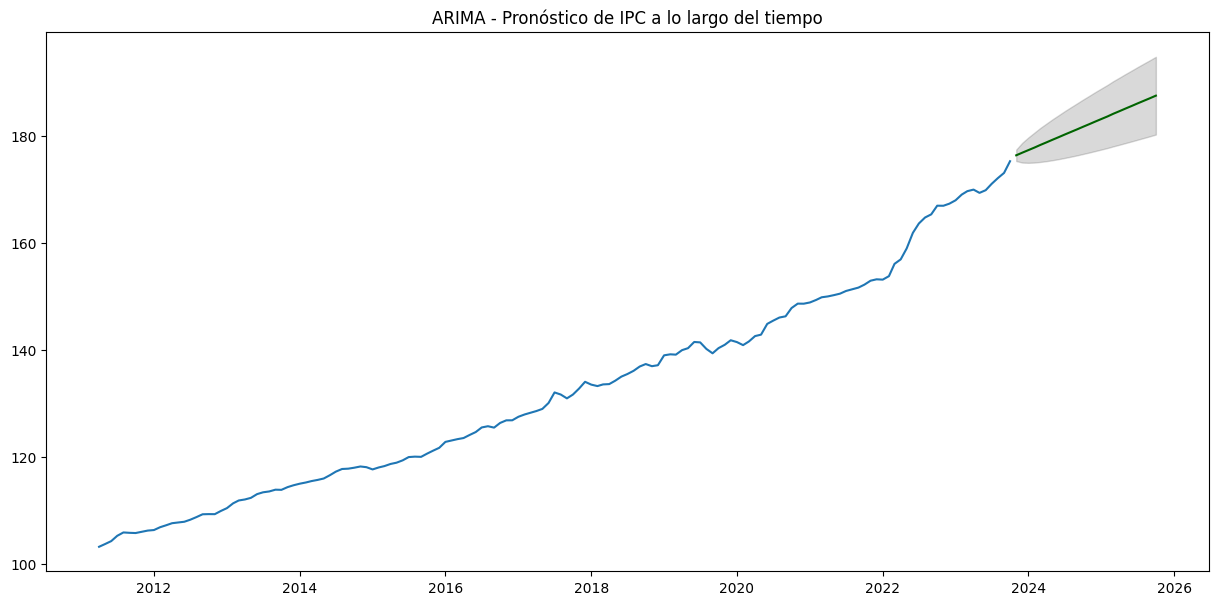

In [16]:
def forecast(ARIMA_model, periods=24):
    # Pronóstico
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # Series para realizar gráficos
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Gráfica
    plt.figure(figsize=(15,7))
    plt.plot(df["Total"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA - Pronóstico de IPC a lo largo del tiempo")
    plt.show()

forecast(ARIMA_model)

Probemos ahora la misa estrategia que antes, con la diferencia de que utilizaremos un modelo SARIMA para tener en cuenta la estacionalidad.

In [21]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["Total"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 es la frecuencia del ciclo
                         start_P=0, 
                         seasonal=True, #configuramos que sí hay estacionalidad
                         d=1, 
                         D=1, #orden de la diferencia de estacionalidad
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Al observar el diagnóstico del modelo, nos percatamos de:

1. El residuo normalizado es mucho más consistente a lo largo del gráfico, lo que significa que los datos están más cerca de ser estacionarios.

2. La curva KDE es similar a la distribución normal.

3. Los puntos de datos se agrupan más cerca de la línea que en el gráfico de diagnóstico de ARIMA.

4. No hay mucho cambio respecto al correlograma.

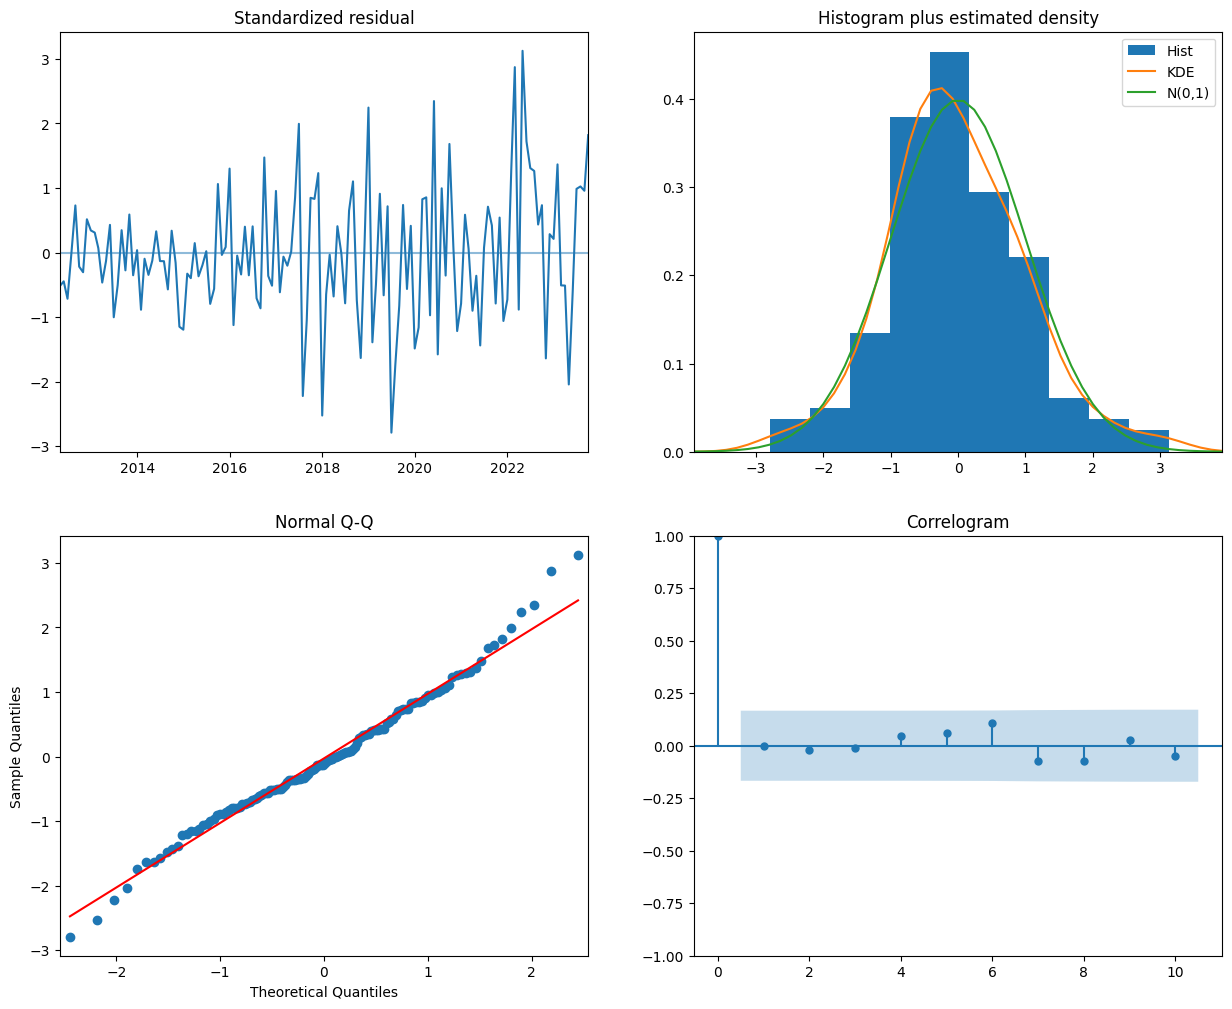

In [22]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

A continuación, podemos utilizar el modelo para prever el IPC de Guatemala en los próximos 24 meses, como hicimos anteriormente.

Como podemos ver, el gráfico siguiente parece mucho más preciso que el modelo ARIMA estándar.

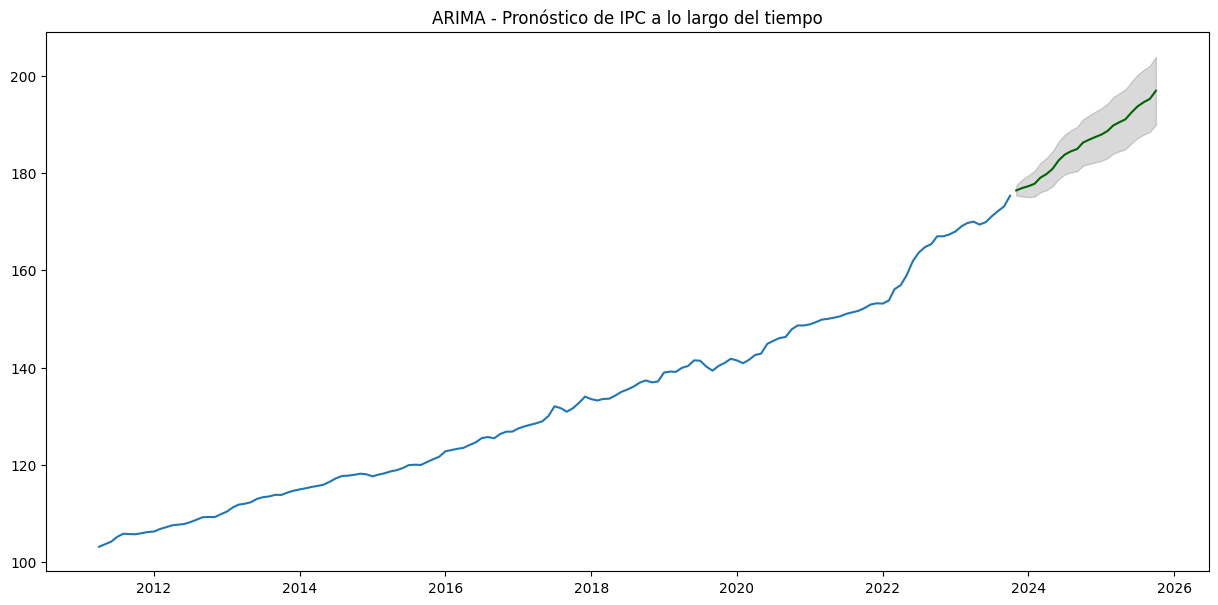

In [23]:

forecast(SARIMA_model)

Ahora vamos a practicar añadiendo una variable exógena. En este ejemplo, simplemente voy a añadir el número de mes como una variable exógena, pero esto no es muy útil ya que esto ya se transmite a través de la estacionalidad.

Observe que estamos añadiendo corchetes adicionales alrededor de los datos que se pasan al modelo SARIMAX.

In [19]:
# Añadiendo variable exógena
df['month_index'] = df.index.month

# Modelo SARIMAX
SARIMAX_model = pm.auto_arima(df[['Total']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  151
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -120.533
Date:                                 Fri, 24 Nov 2023   AIC                            253.067
Time:                                         08:02:31   BIC                            270.674
Sample:                                     04-01-2011   HQIC                           260.222
                                          - 10-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0395      0.078      0.509      0.611      -0.113       0.192
ar.L1          0.9937      0.013     75.773      0.000       0.968       1.019
ma.L1          0.3707      0.075      4.950      0.000       0.224       0.517
ma.S.L12      -0.8824      0.078    -11.263      0.000      -1.036      -0.729
ma.S.L24       0.2013      0.082      2.468      0.014       0.041       0.361
sigma2         0.3012      0.034      8.933      0.000       0.235       0.367
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.68
Prob(Q):                              0.90   Prob(JB):                         0.06
Heteroskedasticity (H):               5.88   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Podemos ver que, de forma similar al modelo SARIMA, estamos obteniendo unas predicciones bastante acertadas y la amplitud del intervalo de confianza pronosticado ha disminuido (de forma muy leve). Esto indica que el modelo podría estar más seguro de sus predicciones.

2023-11-01    176.170083
2023-12-01    176.451968
2024-01-01    176.622542
2024-02-01    176.941514
2024-03-01    177.915987
2024-04-01    178.439580
2024-05-01    179.121525
2024-06-01    180.570603
2024-07-01    181.486000
2024-08-01    181.985365
2024-09-01    182.289882
2024-10-01    183.502696
2024-11-01    183.933563
2024-12-01    184.213262
2025-01-01    184.453010
2025-02-01    184.960958
2025-03-01    185.934358
2025-04-01    186.401710
2025-05-01    186.851891
2025-06-01    188.149208
2025-07-01    189.169042
2025-08-01    189.836508
2025-09-01    190.308050
2025-10-01    191.760234
Freq: MS, dtype: float64


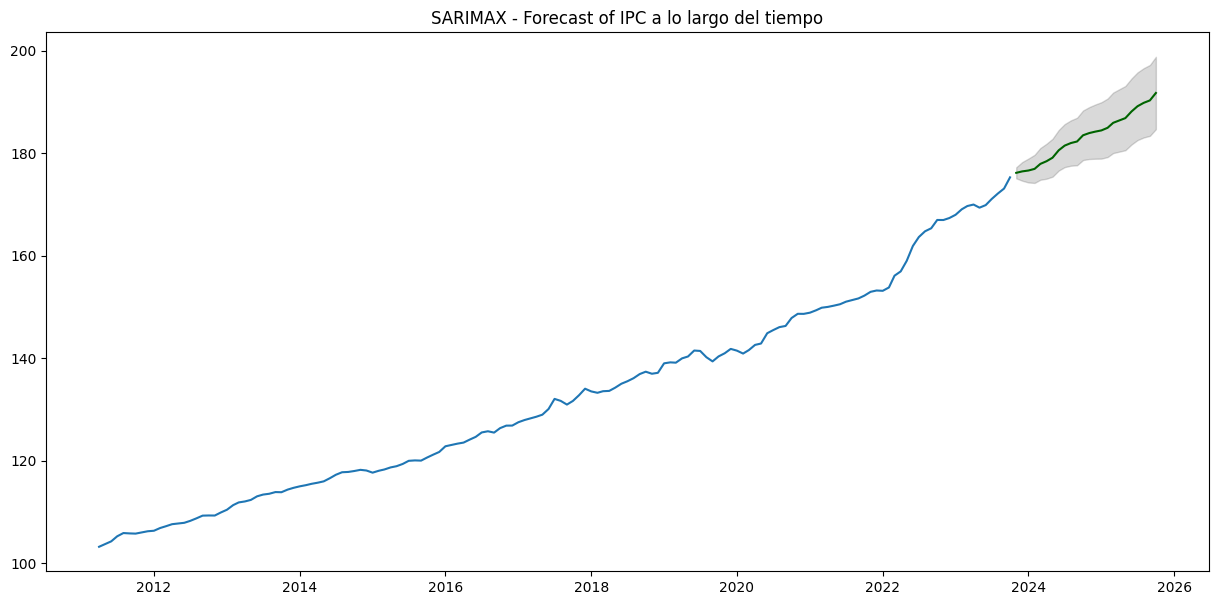

In [25]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Pronóstico
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1]+ pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # Series para realizar gráficos
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    print(fitted_series)
    # Gráfica
    plt.figure(figsize=(15,7))
    plt.plot(df["Total"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of IPC a lo largo del tiempo")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)
